### Introduction to Monte Carlo Simulation in Finance
# Multiasset Simulation

## Cholesky Decomposition

The **Choleski Decomposition** makes an appearance in Monte Carlo Methods where it is used to simulating systems with correlated variables.  Cholesky decomposition is applied to the correlation matrix, providing a lower triangular matrix $A$, which when applied to a vector of uncorrelated samples, $u$, produces the covariance vector of the system. Thus it is highly relevant for quantitative trading.

The standard procedure for generating a set of correlated normal random variables is through a linear combination of uncorrelated normal random variables;
Assume we have a set of $n$ independent standard normal random variables $Z$ and we want to build a set of $n$ correlated standard normals $Z^\prime$ with correlation matrix $\Sigma$
$$
Z^\prime = AZ, \quad \quad AA^t = \Sigma
$$

We can find a solution for $A$ in the form of a triangular matrix
$$
\begin{pmatrix} 
A_{11} & 0 & \dots & 0  \\ 
A_{21} & A_{22} & \dots & 0  \\ 
\vdots & \vdots & \ddots & \dots  \\ 
A_{n1} & A_{n2} & \dots & A_{nn}   
\end{pmatrix}
$$

**diagonal elements**
$$
a_{ii} = \sqrt{\Sigma_{ii} - \sum\limits_{k=1}^{i-1} a_{ik}^2}
$$

**off-diagonal elements**
$$
a_{ij} = \frac{1}{a_{ii}} \left( \Sigma_{ij} - \sum\limits_{k=1}^{i-1} a_{ik} a_{jk} \right)
$$

Using Python, the most efficient method in both development and execution time is to make use of the NumPy/SciPy linear algebra (linalg) library, which has a built in method cholesky to decompose a matrix. The optional lower parameter allows us to determine whether a lower or upper triangular matrix is produced: 

In [153]:
import pprint
import scipy
import scipy.linalg   # SciPy Linear Algebra Library

A = scipy.array([[6, 3, 4, 8], [3, 6, 5, 1], [4, 5, 10, 7], [8, 1, 7, 25]])
L = scipy.linalg.cholesky(A, lower=True)
U = scipy.linalg.cholesky(A, lower=False)

print "A:"
pprint.pprint(A)

print "L:"
pprint.pprint(L)

print "U:"
pprint.pprint(U)

A:
array([[ 6,  3,  4,  8],
       [ 3,  6,  5,  1],
       [ 4,  5, 10,  7],
       [ 8,  1,  7, 25]])
L:
array([[ 2.44948974,  0.        ,  0.        ,  0.        ],
       [ 1.22474487,  2.12132034,  0.        ,  0.        ],
       [ 1.63299316,  1.41421356,  2.30940108,  0.        ],
       [ 3.26598632, -1.41421356,  1.58771324,  3.13249102]])
U:
array([[ 2.44948974,  1.22474487,  1.63299316,  3.26598632],
       [ 0.        ,  2.12132034,  1.41421356, -1.41421356],
       [ 0.        ,  0.        ,  2.30940108,  1.58771324],
       [ 0.        ,  0.        ,  0.        ,  3.13249102]])


For example, for a two-dimension random vector we have simply
$$
A=
\begin{pmatrix} 
\sigma_1        & 0   \\ 
\sigma_2 \rho & \sigma_2 \sqrt{1-\rho^2}   
\end{pmatrix}
$$

Say one needs to generate two correlated normal variables $x_1$ and $x_2$. All one needs to do is to generate two uncorrelated Gaussian random variables $z_1$ and$ z_2$ and set
$$
x_1 = z_1 
$$

$$
x_2 =  \rho z_1 + \sqrt{1-\rho^2} z_2
$$

In Python everything you need is available in the *numpy* library, as we can see in the next example.

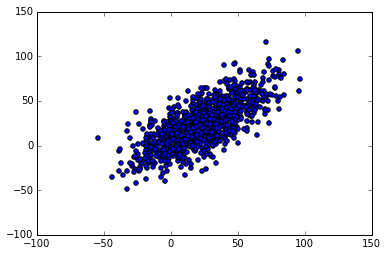

In [154]:
%matplotlib inline

import numpy as np
import scipy as sc

from math        import sqrt
from scipy.stats import norm as scnorm
from pylab       import *
from matplotlib  import pyplot as pl

xx = np.array([-0.51, 51.2])
yy = np.array([0.33, 51.6])
means = [xx.mean(), yy.mean()]  
stds  = [xx.std()  , yy.std() ]
corr  = 0.75      # correlation
covs  = [[stds[0]**2          , stds[0]*stds[1]*corr], 
        [stds[0]*stds[1]*corr,           stds[1]**2]] 

m = np.random.multivariate_normal(means, covs, 1000).T
scatter(m[0], m[1])

## Brownian simulation of correlated assets

When using Monte Carlo methods to price options dependent on a basket of underlying assets (multidimensional stochastic simulations), the correlations between assets should be considered. Here I will show an example of how this can be simulated using pandas. 

Download and prepare the data. First we have downloaded some data from Yahoo producing a csv file ('ts_baket_2.csv') which we can read with the function 'read_csv' from pandas.

In [155]:
import warnings; warnings.simplefilter('ignore')

import pandas as pd
from pandas import Panel, DataFrame

panel_data = pd.read_csv("./data/ts_basket_2.csv", sep=";")
panel_data.tail()
closing = panel_data

Now we can calculate the log returns:

In [156]:
rets = log(closing / closing.shift(1)).dropna()
rets.tail()

,ENEL.MI,DOW_JONES,NASDAQ,NIKKEI225
249,-0.003466,0.009855,0.016278,0.014117
250,0.002312,-0.000459,0.000157,0.001487
251,0.012242,0.007062,0.006780,-0.001305
252,-0.001903,0.000000,-0.008628,-0.003354
253,-0.004199,0.000000,0.006959,0.008569


The correlation matrix has information about the historical correlations between stocks in the group. We work under the assumption that this quantity is conserved, so the generated stocks will need to satisfy this condition:

In [157]:
corr_matrix = rets.corr()
corr_matrix

,ENEL.MI,DOW_JONES,NASDAQ,NIKKEI225
ENEL.MI,1.000000,0.069165,0.118395,0.105514
DOW_JONES,0.069165,1.000000,0.838042,0.114773
NASDAQ,0.118395,0.838042,1.000000,0.082875
NIKKEI225,0.105514,0.114773,0.082875,1.000000


So the most correlated assets are NASDAQ and DOW_JONES. Pandas has a nice utility to plot the correlations:

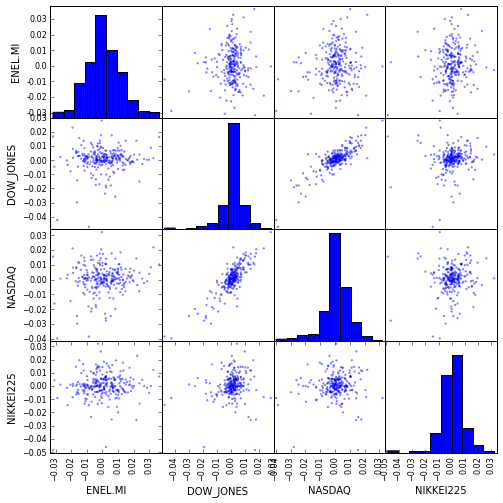

In [158]:
from pandas.tools.plotting import scatter_matrix

scatter_matrix(rets, figsize=(8,8));

### Simulation

The simulation procedure for generating random variables will go like this:

1. Calculate the Cholesky Decomposition matrix, this step will return an upper triangular matrix  $L^T$.
2. Generate random vector  $X \sim N(0,1)$.
3. Obtain a correlated random vector  $Z=XL^T$.

As we have previously seen the Cholesky decomposition of the correlation matrix corr_matrix is impemented in scipy:

In [159]:
from scipy.linalg import cholesky

upper_cholesky = cholesky(corr_matrix, lower=False)
upper_cholesky

array([[ 1.        ,  0.06916545,  0.11839516,  0.10551412],
       [ 0.        ,  0.9976052 ,  0.8318453 ,  0.10773349],
       [ 0.        ,  0.        ,  0.54223241, -0.0354742 ],
       [ 0.        ,  0.        ,  0.        ,  0.98792806]])

We set up the parameters for the simulation:

In [160]:
import numpy as np 
from pandas import bdate_range   # business days

n_days   = 21
dates    = bdate_range(start=closing.iloc[-1].name, periods=n_days)
n_assets = 4
n_sims   = 1000
dt       = 1./252
mu       = rets.mean().values
sigma    = rets.std().values*sqrt(252)

np.random.seed(1234)            # init random number generator for reproducibility

Now we generate the correlated random values $X$:

In [161]:
rand_values = np.random.standard_normal(size = (n_days * n_sims, n_assets)) #
corr_values = rand_values.dot(upper_cholesky)*sigma
corr_values

array([[ 0.08493376, -0.14972207, -0.02352806, -0.06314632],
       [-0.12982127,  0.10821797,  0.16656383, -0.09218189],
       [ 0.00282786, -0.28975161, -0.18463171,  0.1007448 ],
       ..., 
       [-0.13048387, -0.24392647, -0.32786554, -0.41159217],
       [ 0.07860278, -0.14544693, -0.1993493 , -0.10847504],
       [ 0.11462313,  0.11394142,  0.04649467,  0.1012959 ]])

With everything set up we can start iterating through the time interval. The results for each specific time are saved along the third axis of a pandas Panel.

In [162]:
nAsset = 4
symbols = ['ENEL.MI', 'DOW_JONES', 'NASDAQ', 'NIKKEY225']
prices = Panel(items=range(n_sims), minor_axis=symbols, major_axis=dates)

prices.iloc[:, 0, :] =closing.iloc[1].values.repeat(n_sims).reshape(nAsset, n_sims).T

for i in range(1,n_days):
    prices.iloc[:, i, :] = prices.iloc[:, i-1,:] * (exp((mu-0.5*sigma**2)*dt +  sqrt(dt)*corr_values[i::n_days])).T    

prices.iloc[123, :, :].head()   # show random path

,ENEL.MI,DOW_JONES,NASDAQ,NIKKEY225
1970-01-01,4.267931,20949.890630,6095.370117,19445.699220
1970-01-02,4.332839,21030.227994,6142.123468,19465.728425
1970-01-05,4.263437,20883.008372,6113.839177,19352.476706
1970-01-06,4.319626,21035.312342,6142.295173,19439.855471
1970-01-07,4.359759,21051.972525,6143.336477,19177.591089


And thats all! Now it is time to check our results. First a plot of all random paths.

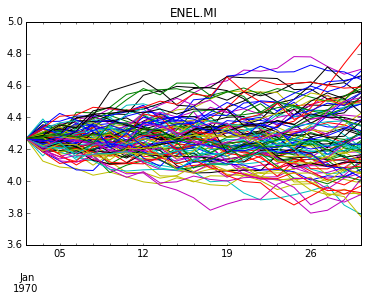

In [163]:
prices.loc[::10, :, 'ENEL.MI'].plot(title='ENEL.MI', legend=False);

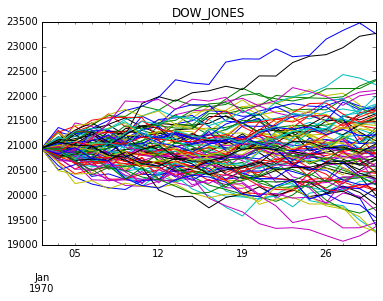

In [164]:
prices.loc[::10, :, 'DOW_JONES'].plot(title='DOW_JONES', legend=False);

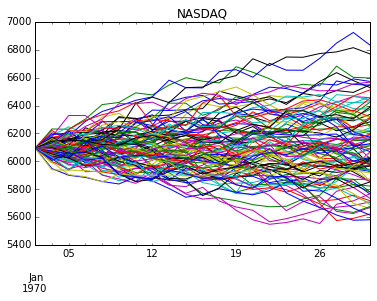

In [165]:
prices.loc[::10, :, 'NASDAQ'].plot(title='NASDAQ', legend=False);

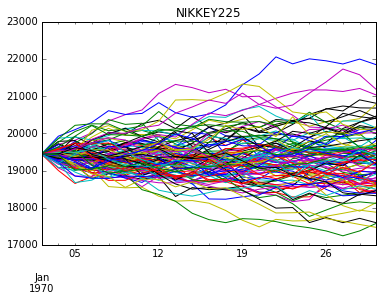

In [166]:
prices.loc[::10, :, 'NIKKEY225'].plot(title='NIKKEY225', legend=False);

We can take a look at the statistics for the last day:

In [167]:
prices.iloc[:, -1, :].T.describe()

,ENEL.MI,DOW_JONES,NASDAQ,NIKKEY225
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,4.263958,20944.281024,6093.996528,19443.259239
std,0.222268,773.604010,257.792741,764.818572
min,3.649861,18868.444588,5304.986917,16621.954726
25%,4.109113,20396.693380,5921.807633,18939.778934
50%,4.252987,20941.248872,6088.625173,19391.118899
75%,4.415194,21463.709486,6270.316920,19966.224466
max,4.881706,23299.632453,7164.874158,21845.385650
